In [33]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Polygon
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


Intro:
For our project, we decided to use 3 main metrics in determining which neighborhood is the best. The metrics we decided on are Crime rate, How often the bus comes on time, and the number of trees in the neighborhood.
The Metric: For our final metric, we decided to weight all 3 of the metrics contained in our datasets as Percentages. For Bus timeliness, we decided to use the metric of how often the bus is on time. 

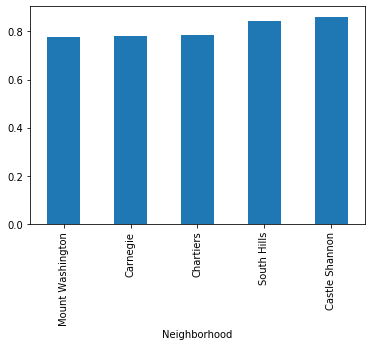

In [14]:
pgh_bus_data = pd.read_csv("https://data.wprdc.org/datastore/dump/00eb9600-69b5-4f11-b20a-8c8ddd8cfe7a",
                           index_col="route", 
                           parse_dates=True)
pgh_bus_data.groupby('route_full_name')['on_time_percent'].mean().sort_values().to_csv('meanOTPbyRoute.csv', header='False') #Writes the Mean OTP per route to a csv file
#Labeled bus routes by neighborhood manually. #Some of these are approximations, since bus routes have a lot of stops.
pgh_bus_data = pd.read_csv("manuallySorted.csv", index_col="Neighborhood")
pgh_bus_data.groupby('Neighborhood')['on_time_percent'].mean().sort_values().to_csv('meanOTPbyNeighborhood.csv', header='False') #We find the mean again because some neighborhoods have multiple routes
pgh_bus_data.groupby('Neighborhood')['on_time_percent'].mean().sort_values().tail().plot.bar()

This graph is of the 5 neighborhoods where the busses are on time most often.

The code below reads in the dataset "arrests.csv" and assigns it to a varriable called crime, displaying the first 5 lines. This dataset is a collection of various arrests made by the City of Pittsburgh Police Department over many years. Each arrest has detailed information about the person arrested as well as the location and the location of the incident. I decided that incident location, more specifically incident neighborhood, was a better statistic than arrest location to assess the level of crime in the area. Arrests are usually only for more severe crimes than noise complaints or other minor offenses, so by sorting the neighborhoods by the number of arrests from incidents within them, a good picture of that neighborhood's safety can be drawn.

In [4]:

crime = pd.read_csv("arrests.csv",index_col="PK")
crime.head()

,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
PK,,,,,,,,,,,,,,,
1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551
1974456,16144120,31.0,M,W,2016-08-03T14:55:00,"4200 Block Steubenville PKE Pittsburgh, PA 15205",13(a)(16) Possession of Controlled Substance,"4200 Block Steubenville PKE Pittsburgh, PA 15205",Outside City,OSC,5599.0,NaN,NaN,-80.088018,40.440136
1974466,16144165,63.0,F,B,2016-08-03T16:45:00,"900 Block Freeport RD Fox Chapel, PA 15238",3929 Retail Theft.,"900 Block Freeport RD Fox Chapel, PA 15238",Westwood,5,2811.0,9.0,2.0,-79.891803,40.486625
1974550,16145257,25.0,F,W,2016-08-05T02:36:00,"Foreland ST & Cedar AV Pittsburgh, PA 15212",5503 Disorderly Conduct. / 5505 Public Drunken...,"Foreland ST & Cedar AV Pittsburgh, PA 15212",East Allegheny,1,2304.0,1.0,1.0,-80.001939,40.454080
1974596,16145962,25.0,M,B,2016-08-06T02:00:00,"900 Block Woodlow ST Pittsburgh, PA 15205",2702 Aggravated Assault. / 2705 Recklessy Enda...,"900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,5,2814.0,2.0,5.0,-80.052204,40.445900


The following code snippet creates the actual metric we used. By getting the value counts for unique entries into 'INCIDENTNEIGHBORHOOD', we get the number of arrests in each neighborhood. From there we can divide by the highest count to create a metric that is between 0 and 1. Since we want 1 to be the best score and 0 the worst, we just subtract the metric by 1 and invert the sign to get the final values.

In [24]:
crime_metric = (crime['INCIDENTNEIGHBORHOOD'].value_counts()/2203-1)*(-1)
crime_metric.to_csv('crimeMetric.csv', header='False')
#manually renamed 'Incident Neighborhood' to 'Neighborhood'

In [31]:
def barGraph(df):
    ob = df['INCIDENTNEIGHBORHOOD'].value_counts()
barGraph(crime)

These are the 20 neighborhoods with the most crime.


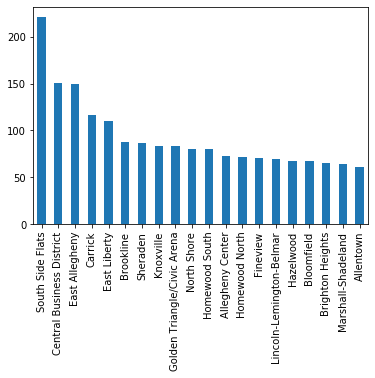

In [32]:
crime['INCIDENTNEIGHBORHOOD'].value_counts().head(20).plot(kind="bar")
# most dangerous neighborhoods (by number of arrests)

These are the 20 neighborhoods with the least crime.


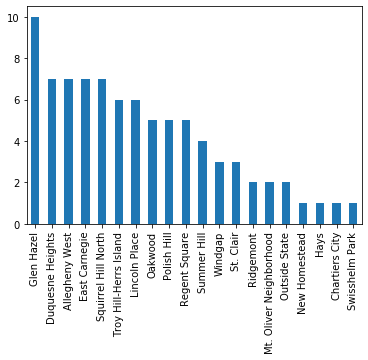

In [23]:
crime['INCIDENTNEIGHBORHOOD'].value_counts().tail(20).plot(kind="bar")
# safest neighborhoods (by number of arrests)

The dataset trees.csv stores the occurence of a tree and its location, and other types of data from trees reported in Allegheny county.

In [27]:
trees = pd.read_csv("trees.csv")
trees.head()

/opt/tljh/user/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,address_number,street,common_name,scientific_name,height,width,growth_space_length,growth_space_width,growth_space_type,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,754166088,7428,MONTICELLO ST,Stump,Stump,0.0,0.0,10.0,2.0,Well or Pit,...,Homewood North,9.0,13.0,4.200313e+10,2.0,13.0,5.0,3-17,40.458169,-79.889724
1,1946899269,220,BALVER AVE,Linden: Littleleaf,Tilia cordata,0.0,0.0,99.0,99.0,Open or Unrestricted,...,Oakwood,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-19,40.429269,-80.067868
2,1431517397,2822,SIDNEY ST,Maple: Red,Acer rubrum,22.0,6.0,6.0,3.0,Well or Pit,...,South Side Flats,3.0,16.0,4.200316e+10,3.0,16.0,3.0,4-24,40.426797,-79.965035
3,994063598,608,SUISMON ST,Maple: Freeman,Acer x freemanii,25.0,10.0,3.0,3.0,Well or Pit,...,East Allegheny,1.0,23.0,4.200356e+10,1.0,23.0,1.0,1-6,40.455503,-79.999276
4,1591838573,1135,N NEGLEY AVE,Maple: Norway,Acer platanoides,52.0,13.0,99.0,99.0,Open or Unrestricted,...,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,3-9,40.476667,-79.924106



* The First metric represents the number of reported trees per neighborhood
* The second metric represent the number of tree based of a fraction of the maximum number of trees in any one location

This data suggests that by the standard of trees, Squirrel Hill South would be the best neighborhood

It is also possible that there are more reports of trees in one area as opposed to another and the metric is not a perfectly accurate representation


In [36]:
maxNum = trees['neighborhood'].value_counts().max()

treeMetric = (trees['neighborhood'].value_counts()/maxNum)
treeMetric.to_csv('treeMetric.csv', header='False')
#Change names of columns manually for consistency

In [29]:
trees['neighborhood'].value_counts()

Squirrel Hill South    5073
Highland Park          2941
Squirrel Hill North    2079
South Side Flats       1693
Shadyside              1558
                       ... 
Arlington Heights         5
Esplen                    3
Glen Hazel                2
South Shore               2
Hays                      1
Name: neighborhood, Length: 90, dtype: int64

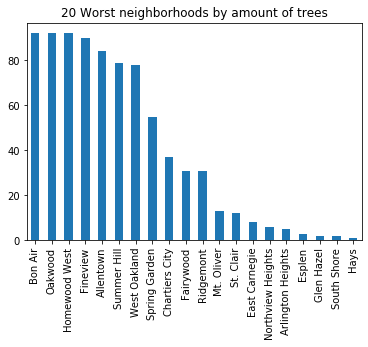

In [69]:


plt.title("20 Worst neighborhoods by amount of trees")
trees['neighborhood'].value_counts().tail(20).plot(kind="bar")



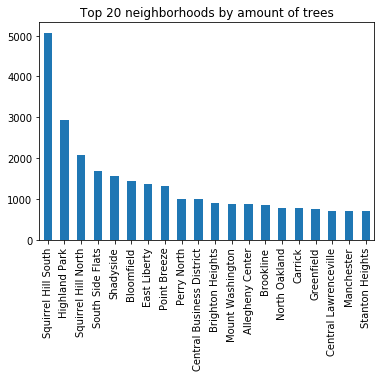

In [70]:
plt.title("Top 20 neighborhoods by amount of trees")
trees['neighborhood'].value_counts().head(20).plot(kind="bar")



* These two graph show the huge differences between the neighborhood's with many trees at the begining of the dataset and conversly, the ones at the end
    * Note that the 20th from last neiborhood "Homewood West" has only about 100 reported tree as opposed to more then 5000 for "Squirrel Hill South"




# Air Quality
## the air quality metric

the ari quality metric comes from a data set which anybody can contriubte to if they smell something, the location is then marked

We ran into issues with this dataset given the dataset did not provide the neighborhood of the smell, However we were able to develop visualizations of the data that contriubte to our presentation and our metric


In [34]:
smellDf = pd.read_csv("smell_reports.csv")
smellDf.columns = smellDf.columns.str.replace(' ', '_')

In [37]:
symptomsAndDescription = smellDf[(smellDf.smell_description.notnull() & smellDf.symptoms.notnull())]
noSymptomsOrDescription = smellDf[(smellDf.smell_description.isnull() & smellDf.symptoms.isnull())]


#5 is the most severe smell of the better smelling
smellVal5best = noSymptomsOrDescription.loc[noSymptomsOrDescription['smell_value'] == 5]
smellVal4best = noSymptomsOrDescription.loc[noSymptomsOrDescription['smell_value'] == 4]
smellVal3best = noSymptomsOrDescription.loc[noSymptomsOrDescription['smell_value'] == 3]
smellVal2best = noSymptomsOrDescription.loc[noSymptomsOrDescription['smell_value'] == 2]
##best of smelling group
smellVal1best = noSymptomsOrDescription.loc[noSymptomsOrDescription['smell_value'] == 1]



#5 worst smell of the bad smells
smellVal5worst = symptomsAndDescription.loc[symptomsAndDescription['smell_value'] == 5]


smellVal4worst = symptomsAndDescription.loc[symptomsAndDescription['smell_value'] == 4]
smellVal3worst = symptomsAndDescription.loc[symptomsAndDescription['smell_value'] == 3]
smellVal2worst = symptomsAndDescription.loc[symptomsAndDescription['smell_value'] == 2]
##best of smelling group
smellVal1worst = noSymptomsOrDescription.loc[noSymptomsOrDescription['smell_value'] == 1]


areSymptoms = smellDf[smellDf.symptoms.notnull()]
noSymptoms = smellDf[smellDf.symptoms.isnull()]

print("Rows with no Symptoms or Description: %s"%len(noSymptomsOrDescription))
print("Rows with Symptoms and Description: %s\n"%len(symptomsAndDescription))

display(smellVal1best)

Rows with no Symptoms or Description: 415
Rows with Symptoms and Description: 308



,epoch_time,date_&_time,smell_value,skewed_latitude,skewed_longitude,zipcode,smell_description,symptoms,additional_comments
0,1584966011,03/23/2020 08:20:11 -04:00,1,40.3387,-79.8178,15132,NaN,NaN,NaN
10,1584991082,03/23/2020 15:18:02 -04:00,1,40.3886,-79.8880,15122,NaN,NaN,NaN
18,1585000833,03/23/2020 18:00:33 -04:00,1,40.4714,-79.9129,15206,NaN,NaN,NaN
20,1585009205,03/23/2020 20:20:05 -04:00,1,40.5319,-80.0147,15237,NaN,NaN,NaN
21,1585032074,03/24/2020 02:41:14 -04:00,1,40.5273,-79.8357,15139,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1067,1587416077,04/20/2020 16:54:37 -04:00,1,40.3064,-80.0458,15102,NaN,NaN,NaN
1084,1587468325,04/21/2020 07:25:25 -04:00,1,40.5522,-80.0008,15237,NaN,NaN,Rained overnight
1086,1587477651,04/21/2020 10:00:51 -04:00,1,40.4150,-79.8792,15218,NaN,NaN,"Haven’t smelled anything in a while, breathing..."
1100,1587547924,04/22/2020 05:32:04 -04:00,1,40.4459,-79.8982,15208,NaN,NaN,NaN



# slicing the dataset

   * here I am isolating the best or most mild smells and the strongest smells based off if there was any symptoms or description of the smell then filtering them by "smell_value" 5 being the strongest and 1 being the most mild



In [46]:
def mapData(df,header):
    fp = "MapData/Allegheny_County_Municipal_Boundaries.shp"

    map_df = geopandas.read_file(fp)
    #display(map_df)
    #display(map_df)
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
    # now let's preview what our map looks like with no data in it

        
    
    #print(map_df.loc[9:5])

    points = geopandas.points_from_xy(df.skewed_longitude, df.skewed_latitude)
    #display(points)
    
    '''
    region = (map_df[["geometry"]])
    
    polygon = list()
    t = 0
    for i in range (len(region)):
        try:
            if(points[i].within(region.iloc[1,i])):
                print("ay")
            polygon.append(region.iloc[1,i])
            t+=1
        except:
            continue
    
    print(polygon)
    
    #print(region)
    '''

    gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.skewed_longitude, df.skewed_latitude))
    #print(gdf)

    # We restrict to South America.
    ax = map_df[map_df.NAME.notnull()].plot(color='white', edgecolor='black',figsize=(12,12))
    
    
    
    class AnyObject:
        pass
    class AnyObjectHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height
            patch = mpatches.Rectangle([x0, y0], width, height, facecolor='red',edgecolor='black', hatch='xx', lw=5,transform=handlebox.get_transform())
            handlebox.add_artist(patch)
            return patch
    
    plt.legend([AnyObject()], [header],handler_map={AnyObject: AnyObjectHandler()})
    
    
    gdf.plot(ax=ax,color="red")

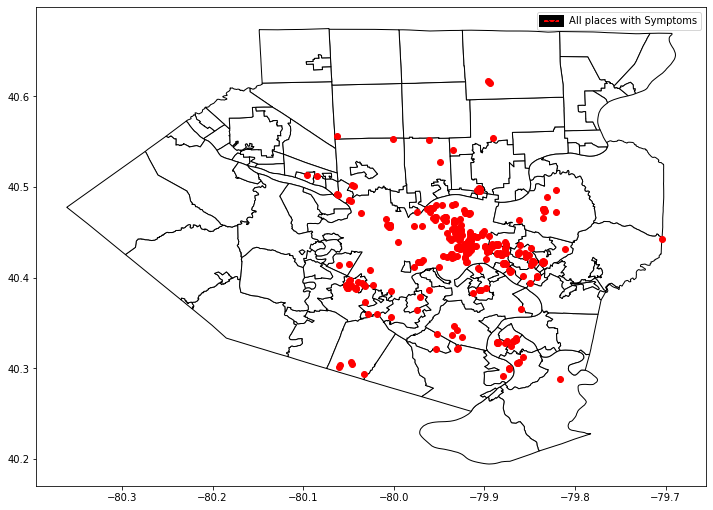

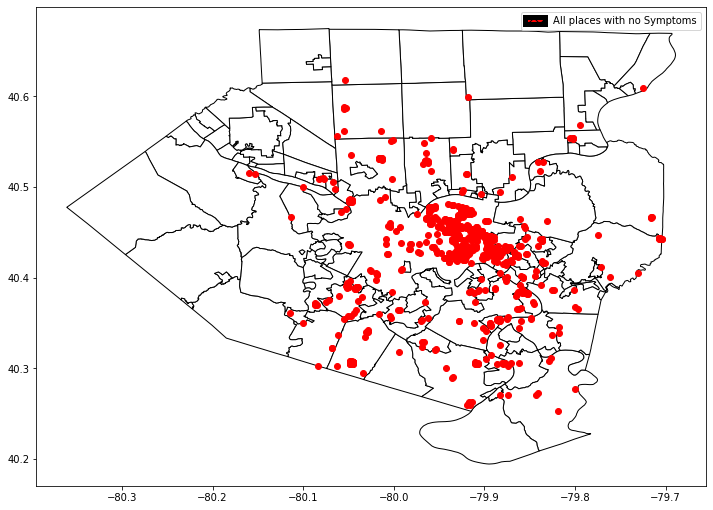

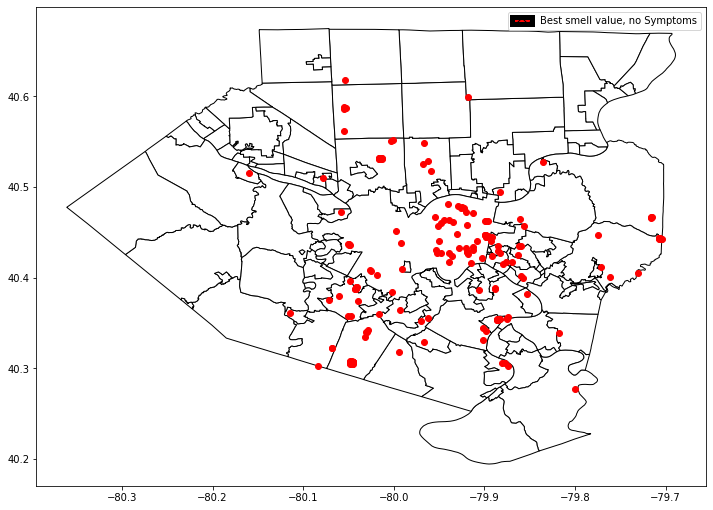

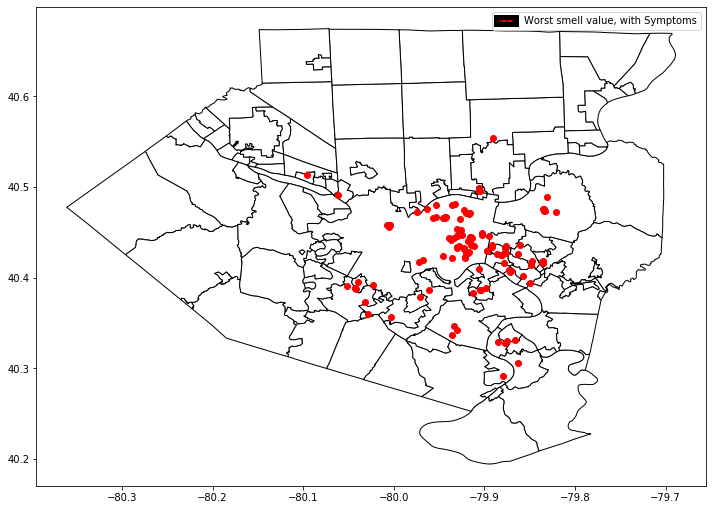

In [48]:
mapData(areSymptoms,"All places with Symptoms")
mapData(noSymptoms,"All places with no Symptoms")
mapData(smellVal1best,"Best smell value, no Symptoms")
mapData(smellVal5worst,"Worst smell value, with Symptoms")


# Maps

* These maps are an important metric, they show allegheny county and map the latitude and longitude of smell reports across the county
* The results seem to be localized towards the center which tells me that there are probably more reports in general being made in this area
* The best smelling area is the area with the least amount of points because that means the area had no reports of smells at all



In [40]:


def barGraph(df,string):
    ob = df['zipcode'].value_counts()
    fig, ax = plt.subplots()
    
    plt.title(string)
    df['zipcode'].value_counts().plot(ax=ax, kind='bar',figsize = (12,5))



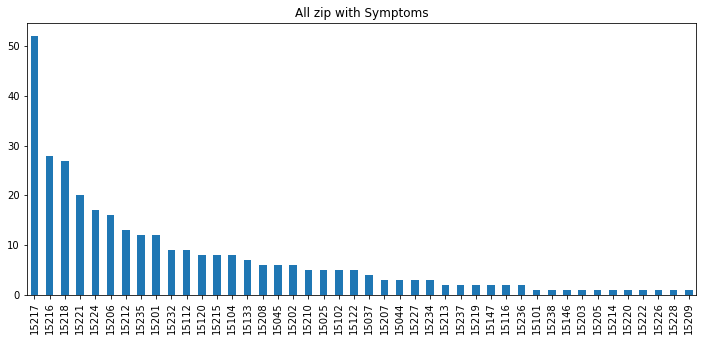

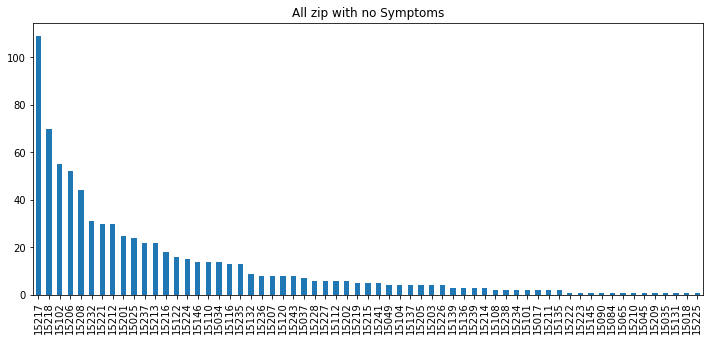

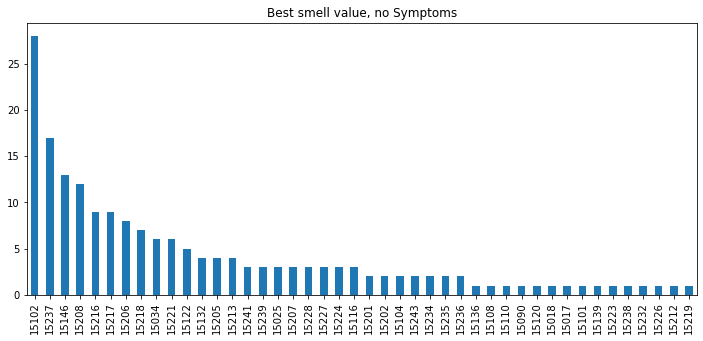

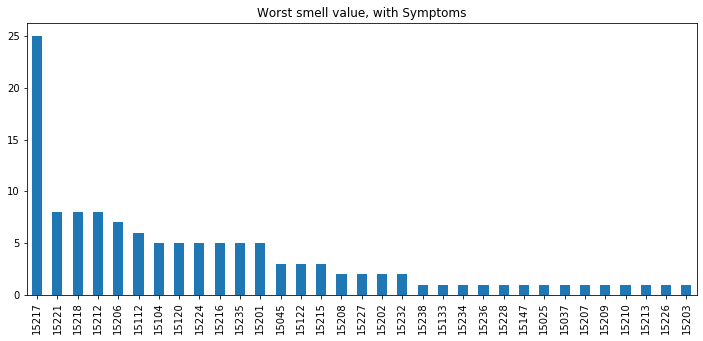

In [41]:
barGraph(areSymptoms,"All zip with Symptoms")
barGraph(noSymptoms,"All zip with no Symptoms")
barGraph(smellVal1best,"Best smell value, no Symptoms")
barGraph(smellVal5worst,"Worst smell value, with Symptoms")


# Bar graphs

* These graps represent the metric of reports per zip code area.
* The zip code 15217 which happens to be "Squirrel Hill South" seems to have the worst smell value overall
* Again the data may not be entirly relyable



# The Best Neighborhood
Below we combine our three metrics into a dataset and average out the values for each neighborhood.

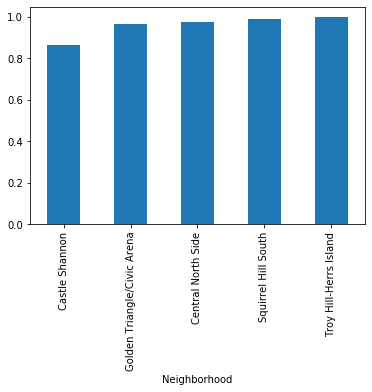

In [75]:
dfCrime = pd.read_csv("crimeMetricFormatted.csv",index_col="Neighborhood")
dfTrees  = pd.read_csv("treeMetricFormatted.csv",index_col="Neighborhood")
dfBusses = pd.read_csv("busMetricFormatted.csv",index_col="Neighborhood")
dfBest= dfCrime.append(dfTrees.append(dfBusses, sort=False), sort=True)
dfBest.groupby('Neighborhood')['Metric'].mean().sort_values().tail().plot(kind='bar')


This method of ranking the neighborhoods uses as much data as is available in determining which neighborhoods are the best. While not all of the neighborhoods are represented in all three data sets, Those that are in multiple are ranked more accurately by considering multiple factors. The best place in Pittsburgh according to these results is Herrs Island.

# Conclusion
* Landin:
    * The results that we ended up with are kind of surprising to me, but also not entirely, considering the kinds of metrics we used. I expected Squirrel Hill to be high up on the list, but Troy Hill being the best neighborhood surprised me. My favorite place in Pittsburgh is still Oakland, even if it doesn't have as many trees as some other places.